### Local Friendliness Violations on a QPU

This notebook is intended to run a benchmark to show a local friendliness violation from an extended Wigner's Friend scenario running on a QPU. For our friends we will use a GHZ state of increasing size. First we run on a simulator, then a noisy simulator, then on a real QPU.

Relevant References:
- https://arxiv.org/abs/2109.02298
- https://arxiv.org/abs/2209.06236

In [10]:
import qiskit
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random

In [11]:
# Quantum Register Layout:
# system; Charlie; Debbie; [Alice]; [Bob]

charlie_size=3
debbie_size=charlie_size

def make_qc(charlie_size=charlie_size, debbie_size=debbie_size):
    return QuantumCircuit(2+charlie_size+debbie_size, 2) # system + Charlie + Debbie, [Alice+Bob]

In [12]:
def bell(qc):
    qc.h(0)
    qc.cx(0, 1)
    return qc

In [35]:
def state_prep(qc):
    #circuit = QuantumCircuit(2)

    # Applying RY Gate on the first Qubit with parameter pi/2
    qc.ry(2 * np.arccos(np.sqrt(2/3)), 0)
    qc.ry(np.pi/4, 1)
    qc.x(0)
    qc.cx(0, 1)
    qc.x(0)
    qc.ry(-np.pi/4, 1) 
    
    return qc

In [36]:
def unitary_measure(qc, system_qubit, friend_qubit, size=1):
    for xx in range(0, size):
        qc.cx(system_qubit, friend_qubit+xx)

In [37]:
def ewfs(qc, alice, bob, angles=None):
    if angles == None:
        angles = [np.pi/2, np.pi/2]
    
    state_prep(qc)
    #bell(qc)
    
    # Charlie measurement
    unitary_measure(qc, 0, 2, size=charlie_size)
    # Debbie measurement
    unitary_measure(qc, 1, 2+charlie_size, size=debbie_size)
    
    # 0: Charlie system; 2: Charlie; [0]: Alice
    if alice == 1:
        # ask Charlie for the outcome
        # we pick a random qubit from Charlie's register
        random_offset = random.randint(0, charlie_size-1)
        qc.measure(2+random_offset, 0)
    else:
        # undo the measurement
        unitary_measure(qc, 0, 2, size=charlie_size)
        # Alice measures directly in a different basis
        qc.rz(np.pi/2, 0)
        qc.rx(np.pi/2, 0)
        if alice == 2:
            qc.rz(angles[0], 0)
        elif alice == 3:
            qc.rz(angles[1], 0)
        qc.measure(0, 0)
    
    # 1: Debbie system; 3: Debbie; [1]: Bob
    if bob == 1:
        # ask Debbie for the outcome
        # we pick a random qubit from Debbie's register
        random_offset = random.randint(0, debbie_size-1)
        qc.measure(2+charlie_size+random_offset, 1)
    else:
        # undo the measurement
        unitary_measure(qc, 1, 2+charlie_size, size=debbie_size)
        # Bob measures directly in a different basis
        qc.rz(np.pi/2, 0)
        qc.rx(np.pi/2, 1)
        if bob == 2:
            qc.rz(angles[0], 1)
        elif bob == 3:
            qc.rz(angles[1], 1)
        qc.measure(1, 1)

    return qc

In [38]:
qc = make_qc()
ewfs(qc, 1, 2)
qc.draw()

┌───────────┐┌───┐        ┌───┐                             ┌─────────┐   »
q_0: ┤ Ry(1.231) ├┤ X ├──■─────┤ X ├──────■─────────■─────────■──┤ Rz(π/2) ├───»
     └┬─────────┬┘└───┘┌─┴─┐┌──┴───┴───┐  │         │         │  └─────────┘   »
q_1: ─┤ Ry(π/4) ├──────┤ X ├┤ Ry(-π/4) ├──┼────■────┼────■────┼───────■────────»
      └─────────┘      └───┘└──────────┘┌─┴─┐  │    │    │    │       │        »
q_2: ───────────────────────────────────┤ X ├──┼────┼────┼────┼───────┼────────»
                                        └───┘  │  ┌─┴─┐  │    │       │     ┌─┐»
q_3: ──────────────────────────────────────────┼──┤ X ├──┼────┼───────┼─────┤M├»
                                               │  └───┘  │  ┌─┴─┐     │     └╥┘»
q_4: ──────────────────────────────────────────┼─────────┼──┤ X ├─────┼──────╫─»
                                             ┌─┴─┐       │  └───┘     │      ║ »
q_5: ────────────────────────────────────────┤ X ├───────┼────────────┼──────╫─»
                                             └───┘     ┌─┴─┐          │      ║ »
q_6: ──────────────────────────────────────────────────┤ X ├──────────┼──────╫─»
                                                       └───┘        ┌─┴─┐    ║ »
q_7: ───────────────────────────────────────────────────────────────┤ X ├────╫─»
                                                                    └───┘    ║ »
c: 2/════════════════════════════════════════════════════════════════════════╩═»
                                                                             0 »
«                                             
«q_0: ────────────────────────────────────────
«                    ┌─────────┐┌─────────┐┌─┐
«q_1: ──■────■────■──┤ Rx(π/2) ├┤ Rz(π/2) ├┤M├
«       │    │    │  └─────────┘└─────────┘└╥┘
«q_2: ──┼────┼────┼─────────────────────────╫─
«       │    │    │                         ║ 
«q_3: ──┼────┼────┼─────────────────────────╫─
«       │    │    │                         ║ 
«q_4: ──┼────┼────┼─────────────────────────╫─
«     ┌─┴─┐  │    │                         ║ 
«q_5: ┤ X ├──┼────┼─────────────────────────╫─
«     └───┘┌─┴─┐  │                         ║ 
«q_6: ─────┤ X ├──┼─────────────────────────╫─
«          └───┘┌─┴─┐                       ║ 
«q_7: ──────────┤ X ├───────────────────────╫─
«               └───┘                       ║ 
«c: 2/══════════════════════════════════════╩═
«                                           1

In [39]:
# Execute the circuit on a quantum simulator
simulator = Aer.get_backend('qasm_simulator')

def execute(ewfs_qc):
    compiled_circuit = transpile(qc, simulator)
    qobj = assemble(compiled_circuit, shots=1000)
    result = simulator.run(qobj).result()
    counts = result.get_counts()
    return counts

In [40]:
execute(qc)

/var/folders/vw/cdx3n5yj7xl3q3g2fv2m676m0000gp/T/ipykernel_5019/584864925.py:7: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = simulator.run(qobj).result()


{'00': 323, '11': 168, '10': 331, '01': 178}

In [41]:
counts = execute(qc)

/var/folders/vw/cdx3n5yj7xl3q3g2fv2m676m0000gp/T/ipykernel_5019/584864925.py:7: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = simulator.run(qobj).result()


In [42]:
numbers = [1, 2, 3]
all_experiments = list(itertools.product(numbers, repeat=2))
print(all_experiments) # all Alice and Bob settings

results = {}
for alice, bob in all_experiments:
    qc = make_qc() # system + Charlie + Debbie, Alice+Bob
    ewfs(qc, alice = alice, bob = bob)
    counts = execute(qc)
    # Convert counts to probabilities
    total_shots = sum(counts.values())
    probabilities = {key: value / total_shots for key, value in counts.items()}

    results[(alice, bob)] = probabilities

[(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]


/var/folders/vw/cdx3n5yj7xl3q3g2fv2m676m0000gp/T/ipykernel_5019/584864925.py:7: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = simulator.run(qobj).result()


In [43]:
results

{(1, 1): {'10': 0.328, '00': 0.36, '01': 0.312},
 (1, 2): {'11': 0.145, '00': 0.356, '10': 0.314, '01': 0.185},
 (1, 3): {'01': 0.164, '00': 0.329, '10': 0.337, '11': 0.17},
 (2, 1): {'10': 0.174, '11': 0.168, '00': 0.658},
 (2, 2): {'01': 0.072, '11': 0.074, '00': 0.429, '10': 0.425},
 (2, 3): {'01': 0.076, '10': 0.428, '00': 0.396, '11': 0.1},
 (3, 1): {'11': 0.166, '10': 0.152, '00': 0.682},
 (3, 2): {'01': 0.089, '10': 0.438, '11': 0.08, '00': 0.393},
 (3, 3): {'01': 0.08, '11': 0.082, '00': 0.415, '10': 0.423}}

In [44]:
def marginalize(bitstring_probs, indices):
    marginalized_probs = {}
    for bitstring, prob in bitstring_probs.items():
        # Extract the bits at the specified indices
        marginalized_bitstring = ''.join([bitstring[i] for i in indices])
        
        # Add the probability to the marginalized_probs dictionary
        if marginalized_bitstring in marginalized_probs:
            marginalized_probs[marginalized_bitstring] += prob
        else:
            marginalized_probs[marginalized_bitstring] = prob
            
    return marginalized_probs

In [45]:
def single_expect(observer, setting, results): #obs = 0 for Alice and 2 for Bob
    expect = 0
    denom = 0
    for settings, probs in results.items():
        if settings[observer] == setting:
            expect += marginalize(probs, [observer])['1']
            denom += 1
    return expect / denom

In [46]:
single_expect(0, 1, results)

0.43133333333333335

In [47]:
def double_expect(settings, results):
    probs = results[settings]
    try:
        val = probs['11']
    except KeyError:
        val = 0
    return val

In [48]:
double_expect((1, 2), results)

0.145

In [49]:
def check_LF1(results):
    singles = -single_expect(0, 1, results) - single_expect(0, 2, results)
    singles += -single_expect(1, 1, results) - single_expect(1, 2, results)
    a1b1 = double_expect((1, 1), results)
    a1b2 = double_expect((1, 2), results)
    a2b1 = double_expect((2, 1), results)
    a2b2 = double_expect((2, 2), results)
    a2b3 = double_expect((2, 3), results)
    a3b2 = double_expect((3, 2), results)
    a3b3 = double_expect((3, 3), results)
    singles += -a1b1 - 2*a1b2 - 2*a2b1 + 2*a2b2
    singles += -a2b3 - a3b2 - a3b3
    return singles - 6 # a violation of LF is when > 0

In [50]:
check_LF1(results)

-8.058

In [28]:
def run_ewfs(angles):
    numbers = [1, 2, 3]
    all_experiments = list(itertools.product(numbers, repeat=2))

    results = {}
    for alice, bob in all_experiments:
        qc = make_qc() # system + Charlie + Debbie, Alice+Bob
        ewfs(qc, alice = alice, bob = bob, angles=angles)
        counts = execute(qc)
        # Convert counts to probabilities
        total_shots = sum(counts.values())
        probabilities = {key: value / total_shots for key, value in counts.items()}

        results[(alice, bob)] = probabilities
    return results

In [29]:
grid = np.linspace(0, np.pi/2, 20)
lf_vals = np.zeros((len(grid), len(grid)))
for t1, t2 in itertools.product(range(0, len(grid)), range(0, len(grid))):
    res = run_ewfs([grid[t1], grid[t2]])
    lf_vals[t1][t2] = check_LF1(res)

/var/folders/vw/cdx3n5yj7xl3q3g2fv2m676m0000gp/T/ipykernel_5019/584864925.py:7: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = simulator.run(qobj).result()


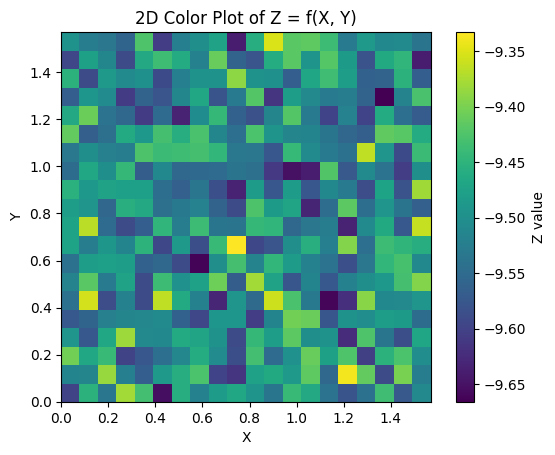

In [30]:
# Create a 2D color plot using imshow
X, Y = grid, grid
Z = lf_vals
plt.imshow(Z, extent=[X.min(), X.max(), Y.min(), Y.max()], origin='lower', cmap='viridis')
plt.colorbar(label='Z value')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Color Plot of Z = f(X, Y)')
plt.show()

### Projector Math

In [119]:
H = np.asarray([1, 0])
V = np.asarray([0, 1])

In [164]:
rads = lambda degrees: degrees / 360 * 2 * np.pi
args = [rads(168), 0, rads(118)]
beta = rads(175)

ketphi = lambda x: 1 / np.sqrt(2) * (H + np.exp(1.j * args[x-1]) * V)
Pi_a = lambda x: np.outer(ketphi(x), ketphi(x))
A = lambda x: 2*Pi_a(x) - np.outer(H, H) - np.outer(V, V)

ketbeta = lambda x: 1 / np.sqrt(2) * (H + np.exp(1.j * (beta-args[x-1])) * V)
Pi_b = lambda x: np.outer(ketbeta(x), ketbeta(x))
B = lambda x: 2*Pi_b(x) - np.outer(H, H) - np.outer(V, V)

In [168]:
A(2)

array([[-2.22044605e-16+0.j,  1.00000000e+00+0.j],
       [ 1.00000000e+00+0.j, -2.22044605e-16+0.j]])

In [167]:
B(2)

array([[-2.22044605e-16+0.j        , -9.96194698e-01+0.08715574j],
       [-9.96194698e-01+0.08715574j, -1.51922470e-02-0.17364818j]])